<a href="https://colab.research.google.com/github/sandeep-selvaraj/amda-bonus-task/blob/master/bonus_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, torchvision
from fastai.vision.all import *
from sklearn.metrics import classification_report

from pathlib import Path
import csv

from PIL import Image

import pandas as pd

## Download the Dataset

In [ ]:
def download_dataset():
        current_dir = Path.cwd()
        dataset_dir = current_dir.joinpath("dataset")
        dataset_dir.mkdir(exist_ok=True)
        torchvision.datasets.GTSRB(dataset_dir, download=True)
        return dataset_dir

In [ ]:
# Download GTSRB dataset to local disk and store root path

dataset_dir = download_dataset()

100%|██████████| 187490228/187490228 [00:08<00:00, 23246703.98it/s]


Extracting /content/dataset/gtsrb/GTSRB-Training_fixed.zip to /content/dataset/gtsrb


## Load data from local disk to a __dict__

### Expected format of dict:
### { "classid+file_name": "path" }

In [ ]:
def get_all_image_from_dataset(dataset_dir):
    path_to_training = dataset_dir.joinpath("gtsrb/GTSRB/Training")
    image_path = {}
    for folder in path_to_training.iterdir():
        for image in folder.glob("*.ppm"):
            image_path[folder.stem+"-"+image.stem] = image
    return image_path

In [ ]:
images = get_all_image_from_dataset(dataset_dir)

In [ ]:
print(f"Total Number of images in the datset:{len(images)}")

Total Number of images in the datset:26640


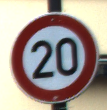

In [ ]:
Image.open(images['00000-00004_00029'])

![alt text](class_details.png "Class Details")

## Reference: https://www.researchgate.net/publication/322945549_Traffic_sign_recognition_and_classification_with_modified_residual_networks#pf1

In [ ]:
data_loader = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
).dataloaders(dataset_dir)

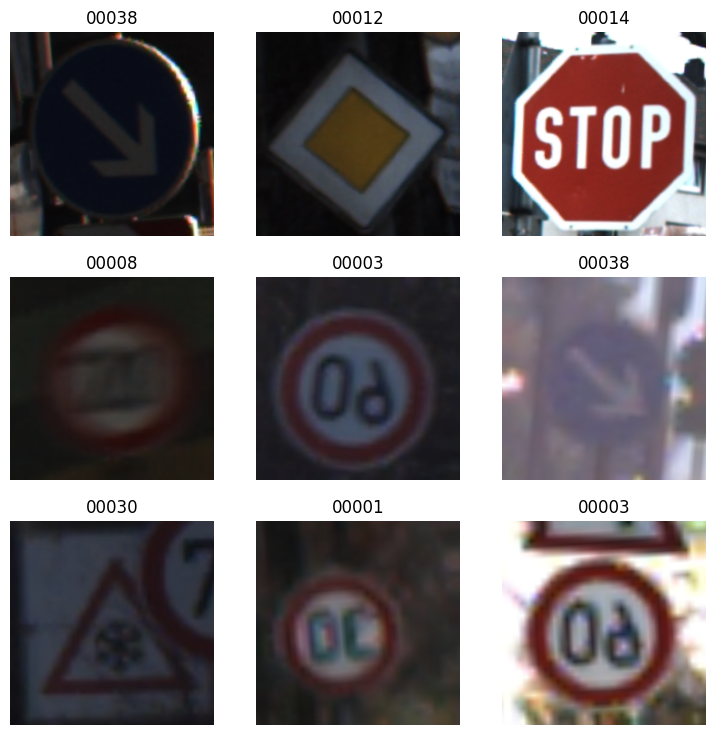

In [ ]:
data_loader.show_batch()

In [ ]:
print(f"The number of images for training:{len(data_loader.train.items)}")
print(f"The number of images for testing:{len(data_loader.valid.items)}")

The number of images for training:21312
The number of images for testing:5328


As there was no Train-test split ratio defined while loading the data into the datablocker, that default 80-20 ratio has been used.

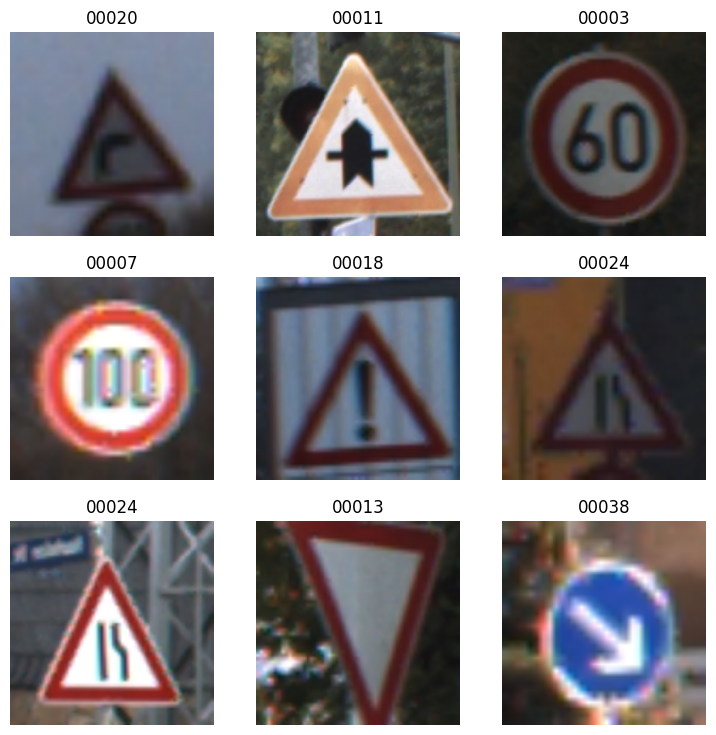

In [ ]:
data_loader.valid.show_batch()

In [ ]:
learner = vision_learner(data_loader, models.resnet50, metrics=error_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
learner.fit_one_cycle(n_epoch=3)

epoch,train_loss,valid_loss,error_rate,time
0,0.431333,0.166522,0.052740,03:16
1,0.114339,0.037503,0.012950,03:16
2,0.051196,0.023610,0.008446,03:17


## Training of the model and initial observation

To get a sense how well the model can learn, it was learned for 3 epochs. Looking at the reducing loss, it can be said that the model is learning well, however few more learnings need to be carried out to get an understanding of how well the model's learnt. This too cannot be said as early stopping.

Fine-Tuning the model to adapt to the new dataset

In [ ]:
learner.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.114365,0.053047,0.016517,03:17


epoch,train_loss,valid_loss,error_rate,time
0,0.041378,0.011968,0.003378,04:15


In [ ]:
image, ground_truth_values = learner.get_preds(ds_idx=1)

Now, from our predictions we have got from above, we need to validate if they correct or wrong with ground truth(True labels). Let's load the ground truth values to a list. Remember, **folder_name** is the correct value or ground truth.

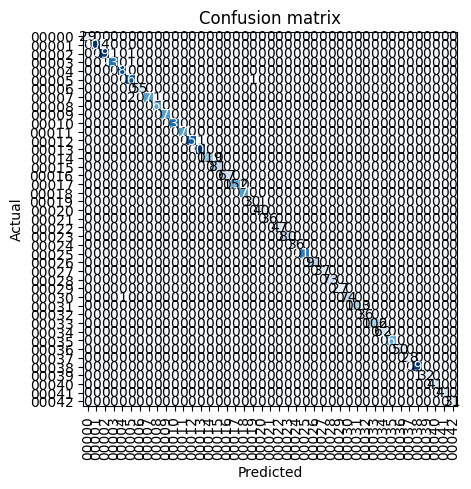

In [ ]:
interpreter = ClassificationInterpretation.from_learner(learner)
interpreter.plot_confusion_matrix()

In [ ]:
confusion_matrix.shape

(43, 43)

In [ ]:
true_positives = np.diag(confusion_matrix)
true_negatives = np.diag(confusion_matrix)[::-1]
false_positives = confusion_matrix.sum(axis=0) - true_positives
false_negatives = confusion_matrix.sum(axis=1) - true_positives

To get a more comprehensive understanding to a finer detail, let's calculate to key classification metrics for each class.

Precision = True Positve/ (True Positive + False Positive)
Recall = True Positive/ (True Positive + False Negative)

https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

In [ ]:
metrics_report = classification_report(ground_truth_values, image.argmax(dim=1))
print(metrics_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      0.99      0.99       311
           2       0.98      0.99      0.99       298
           3       1.00      0.99      0.99       232
           4       1.00      1.00      1.00       280
           5       0.99      1.00      0.99       265
           6       1.00      1.00      1.00        55
           7       1.00      0.98      0.99       177
           8       0.99      1.00      1.00       169
           9       1.00      1.00      1.00       175
          10       1.00      1.00      1.00       235
          11       1.00      1.00      1.00       171
          12       1.00      1.00      1.00       259
          13       1.00      1.00      1.00       307
          14       1.00      1.00      1.00       119
          15       1.00      1.00      1.00        81
          16       1.00      1.00      1.00        67
          17       1.00    

## Inference from the first model (Using Pre-trained RESNET30)

There seems to be good accuracy, and good precision and recall rate across all the classes, which makes it look like the trained model has learnt well. But, there could be a possibility of overfitting, if the model doesn't perform well for unseen data but that would not be likely, as these are pre-trained models and it tends to work better. Maybe, a way to prove that pre-trained models work better, training a new model could prove the hypothesis

# Depreceated (Code excess or redundant)

In [ ]:
data_loader.valid.items

[Path('/content/dataset/gtsrb/GTSRB/Training/00020/00003_00001.ppm'),
 Path('/content/dataset/gtsrb/GTSRB/Training/00011/00005_00026.ppm'),
 Path('/content/dataset/gtsrb/GTSRB/Training/00003/00006_00018.ppm'),
 Path('/content/dataset/gtsrb/GTSRB/Training/00007/00010_00019.ppm'),
 Path('/content/dataset/gtsrb/GTSRB/Training/00018/00016_00027.ppm'),
 Path('/content/dataset/gtsrb/GTSRB/Training/00024/00000_00013.ppm'),
 Path('/content/dataset/gtsrb/GTSRB/Training/00024/00001_00021.ppm'),
 Path('/content/dataset/gtsrb/GTSRB/Training/00013/00026_00023.ppm'),
 Path('/content/dataset/gtsrb/GTSRB/Training/00038/00008_00015.ppm'),
 Path('/content/dataset/gtsrb/GTSRB/Training/00011/00024_00021.ppm'),
 Path('/content/dataset/gtsrb/GTSRB/Training/00010/00032_00023.ppm'),
 Path('/content/dataset/gtsrb/GTSRB/Training/00040/00000_00026.ppm'),
 Path('/content/dataset/gtsrb/GTSRB/Training/00009/00021_00000.ppm'),
 Path('/content/dataset/gtsrb/GTSRB/Training/00018/00001_00013.ppm'),
 Path('/content/data

In [ ]:
ground_truth_values = []
for folder in data_loader.valid.items:
    *_, class_name, _ = str(folder).split("/")
    ground_truth_values.append(int(class_name))

In [ ]:
true_predictions = 0
false_predictions = 0

for prediction, ground_truth in zip(predicted_value, ground_truth_values):
  if prediction == ground_truth:
    print("yes")

Streaming output truncated to the last 5000 lines.
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
y

## Load the annotated values, i.e, the target value from the CSV file

## Note: As depicted in the readme, each cell of the csv file has the following details:-
### [Filename;Width;Height;Roi.xi;Roi.yi;Roi.xj;Roi.xj;classId]

In [ ]:
image_annotation_list = []
path_to_training = dataset_dir.joinpath("gtsrb/GTSRB/Training")
for folder in path_to_training.iterdir():
    for csv_file in folder.glob("*.csv"):
        with open(csv_file, newline='') as file:
            reader = csv.reader(file,delimiter=';')
            data = list(reader)
    image_annotation_list.extend(data)
    #     image_annotation_data = pd.read_csv(csv_file)
    # image_annotation.append(image_annotation_data)

In [ ]:
image_annotation_list

[['Filename',
  'Width',
  'Height',
  'Roi.X1',
  'Roi.Y1',
  'Roi.X2',
  'Roi.Y2',
  'ClassId'],
 ['00000_00000.ppm', '29', '30', '5', '6', '24', '25', '0'],
 ['00000_00001.ppm', '30', '30', '5', '5', '25', '25', '0'],
 ['00000_00002.ppm', '30', '30', '5', '5', '25', '25', '0'],
 ['00000_00003.ppm', '31', '31', '5', '5', '26', '26', '0'],
 ['00000_00004.ppm', '30', '32', '5', '6', '25', '26', '0'],
 ['00000_00005.ppm', '31', '31', '6', '6', '26', '26', '0'],
 ['00000_00006.ppm', '33', '34', '6', '6', '28', '28', '0'],
 ['00000_00007.ppm', '34', '35', '6', '6', '29', '30', '0'],
 ['00000_00008.ppm', '33', '34', '5', '5', '28', '29', '0'],
 ['00000_00009.ppm', '36', '36', '6', '5', '30', '30', '0'],
 ['00000_00010.ppm', '35', '36', '5', '5', '30', '31', '0'],
 ['00000_00011.ppm', '37', '38', '6', '6', '32', '33', '0'],
 ['00000_00012.ppm', '37', '38', '5', '6', '32', '33', '0'],
 ['00000_00013.ppm', '40', '39', '6', '5', '35', '34', '0'],
 ['00000_00014.ppm', '41', '42', '5', '6', '36'

In [ ]:
image_annotation[0]

NameError: name 'image_annotation' is not defined

In [ ]:
type(test_image)

In [ ]:
image_folder = [ folder for folder in path_to_training.iterdir() ]